In [1]:
import torch
from torch import nn
from pytorch_lightning import LightningModule
import torchvision as tv
from torchvision import transforms
import torch.nn.functional as F
import torch.utils.data as data_utils

import pytorch_lightning as pl
from pytorch_lightning import Trainer
from torch.utils.data import DataLoader

from collections import OrderedDict
from pytorch_lightning.loggers import WandbLogger
import wandb
import random

import warnings

In [2]:
from model import *

In [3]:
workers=8
batch_size=16

## creating and downloading data


In [4]:
data_train=DataLoader(tv.datasets.CIFAR10("../data/01_raw",transform=transforms.ToTensor(), download=True), batch_size=batch_size, num_workers=workers)
#data_val=DataLoader(tv.datasets.CIFAR10("../data/01_raw", transform=transforms.ToTensor() , train=False ), batch_size=batch_size, num_workers=workers)

Files already downloaded and verified


In [5]:
oneclass_data=[]
for d in data_train:
    data, labels=d
  #  print(labels)
    for l in range(len(labels)):
        if labels[l]==0:
            oneclass_data.append(data[l].view(1,3,32,32))

In [70]:
oneclass_dataloader=DataLoader(data_utils.TensorDataset(torch.cat(oneclass_data, dim=0), torch.zeros(len(oneclass_data))),  batch_size=batch_size, num_workers=workers, shuffle=True)

Load or create new

In [7]:
checkpoint = torch.load('../data/06_models/no_img_norm_32.ckpt')
print(checkpoint["hyper_parameters"])


{'lr': 0.0001, 'latent_size': 512, 'final_res': 32, 'curr_res': 32, 'k': 1, 'alpha': 0, 'alpha_step': 0.0016875000000000002, 'normalize': True, 'device': 'cuda', 'normalize_img': False}


In [21]:
model = PGAN_loaded.load_from_checkpoint(
    checkpoint_path="../data/06_models/no_img_norm_32.ckpt", normalize_img=False)
wandb.finish()
wandb_logger=None

alpha,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▃▃▃▃▃▆▆▆▆██
curr_res,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁███████████
discriminator_loss,█▅▄▅▄▄▄▃▄▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▄▃▁▁▁▁▂▂▃▃▃▃
epoch,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▆▇▇▇▇██
generator_loss,▁▃▅▅▅▄▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▄██▇▇▅▅▄▄▃▃
trainer/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇███
alpha,0.225
curr_res,8.0
discriminator_loss,-2.12863
epoch,9
generator_loss,3.73144


In [11]:
wandb_logger = WandbLogger(project="PGAN",  name='locally_airplanes_continue_32' ,entity="dl_image_classification")

wandb: Currently logged in as: kpuchalskixiv (dl_image_classification). Use `wandb login --relogin` to force relogin


In [12]:
model.generator.device='cuda'
trainer = Trainer(gpus=1, max_epochs=600, log_every_n_steps=50, logger=wandb_logger)
trainer.fit(model, oneclass_dataloader)#, ckpt_path="epoch=1170-step=733046.ckpt")

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type          | Params
------------------------------------------------
0 | generator     | Generator     | 20.7 M
1 | discriminator | Discriminator | 20.7 M
------------------------------------------------
41.4 M    Trainable params
0         Non-trainable params
41.4 M    Total params
165.771   Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

RuntimeError: DataLoader worker (pid(s) 96244, 90356) exited unexpectedly

In [18]:
model =  PGAN(lr=1e-4, latent_size=512, final_res=32, activation_f=nn.LeakyReLU(negative_slope=0.2), 
             alpha_step=1e-1, # 500 epochs on 4v4, 1k on both 8x8 and 16x16
             loss_f=WGANGP_loss)
wandb.finish()
wandb_logger=None

alpha,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇██
curr_res,▁▁▁▁▁▁▁▁▁▁▁▁▁▁██████████████████████████
discriminator_loss,█▅▅▄▄▄▃▃▃▄▄▃▄▄▁▂▂▂▃▃▃▃▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄
epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
generator_loss,▄▅▅▅▄▄▄▄▃▃▃▃▂▂██▆▅▅▄▃▃▂▂▂▂▂▂▂▃▂▂▁▁▂▂▂▂▁▁
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
alpha,0.975
curr_res,8.0
discriminator_loss,-1.03303
epoch,19
generator_loss,1.23739


In [19]:
wandb_logger = WandbLogger(project="PGAN",  name='test_logging_imgs' ,entity="dl_image_classification")

In [20]:
model.generator.device='cuda'
trainer = Trainer(gpus=1, max_epochs=20, log_every_n_steps=50, logger=wandb_logger)
trainer.fit(model, oneclass_dataloader)#, ckpt_path="epoch=171-step=107672.ckpt")

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type          | Params
------------------------------------------------
0 | generator     | Generator     | 6.6 M 
1 | discriminator | Discriminator | 6.6 M 
------------------------------------------------
13.1 M    Trainable params
0         Non-trainable params
13.1 M    Total params
52.472    Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

/home/kacper/anaconda3/envs/pgan/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:726: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


In [38]:
model.current_epoch

1171

In [13]:
wandb.finish()

alpha,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
curr_res,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
discriminator_loss,█▆▄▅▇▇█▅▅▄▇▅▅▃▄▇▆▆▅▇▇▅▅▅▅▅▆▇▂▅▄▅▆▅▇▆▄▆▅▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
generator_loss,▅▄▅▃▄▅▅▅▆▇▃▇▄▆█▆▃█▅▄▅▅▆▃▅▆▆▇▆▄▅▄▅▅▄▅▄▅▇▁
trainer/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
alpha,0.93994
curr_res,32.0
discriminator_loss,-2.24519
epoch,334
generator_loss,0.85832


In [14]:
torch.save(model, 'local_airplanes_32.model')

# Debugging

In [20]:
model.generator.residual=None

In [52]:
latent_vec=F.normalize(torch.rand(batch_size,512), p=2, dim=1)
latent_vec
model.to('cpu')
model.generator.to('cpu')
model.generator.device='cpu'
model.discriminator.to('cpu')
model.discriminator.device='cpu'
model.eval()
model.generator.eval()
model.discriminator.eval()

Discriminator(
  (f): LeakyReLU(negative_slope=0.2)
  (minibatch_layer): miniBatchStdDev()
  (layers): ModuleList(
    (0): EqualizedConv2d(
      (module): Conv2d(3, 512, kernel_size=(1, 1), stride=(1, 1))
    )
    (1): LeakyReLU(negative_slope=0.2)
    (2): EqualizedConv2d(
      (module): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (3): LeakyReLU(negative_slope=0.2)
    (4): EqualizedConv2d(
      (module): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (5): LeakyReLU(negative_slope=0.2)
    (6): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (7): LeakyReLU(negative_slope=0.2)
    (8): EqualizedConv2d(
      (module): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (9): LeakyReLU(negative_slope=0.2)
    (10): EqualizedConv2d(
      (module): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (11): LeakyReLU(negative_slope=0.2)
    (12): AvgPool2d(kernel_size=

In [46]:
model.hparams

"alpha":         0
"alpha_step":    0.0016875000000000002
"curr_res":      32
"device":        cuda
"final_res":     32
"k":             1
"latent_size":   512
"loss_f":        <function WGANGP_loss at 0x7f5ddb1839d0>
"lr":            0.0001
"normalize":     True
"normalize_img": False

torch.Size([3, 32, 32])


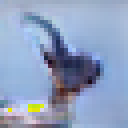

torch.Size([3, 32, 32])


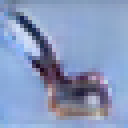

torch.Size([3, 32, 32])


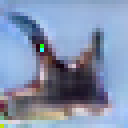

torch.Size([3, 32, 32])


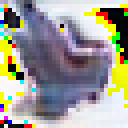

torch.Size([3, 32, 32])


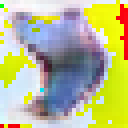

torch.Size([3, 32, 32])


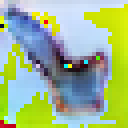

torch.Size([3, 32, 32])


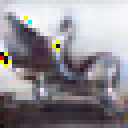

torch.Size([3, 32, 32])


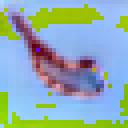

torch.Size([3, 32, 32])


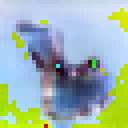

torch.Size([3, 32, 32])


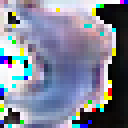

torch.Size([3, 32, 32])


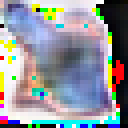

torch.Size([3, 32, 32])


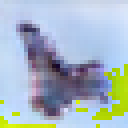

torch.Size([3, 32, 32])


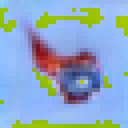

torch.Size([3, 32, 32])


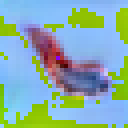

torch.Size([3, 32, 32])


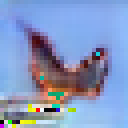

torch.Size([3, 32, 32])


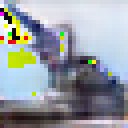

In [64]:
decisions_gen=[]
gen_imgs=model.generator(latent_vec)
i=0
t=transforms.Compose([ transforms.ToPILImage()])#, transforms.Resize(size=(256,256))])
for img in gen_imgs: 
    print(img.shape)
    img=img.view(1, 3, model.hparams.curr_res,model.hparams.curr_res)
    decisions_gen.append(model.discriminator(img).detach().numpy())
    
    img_upsampled=(nn.Upsample(scale_factor=(4,4), mode='nearest')(img.view(1, 3, model.hparams.curr_res,model.hparams.curr_res)))[0]
    display(t(img_upsampled)) 
    
    


torch.Size([3, 32, 32])


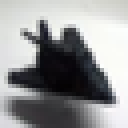

torch.Size([3, 32, 32])


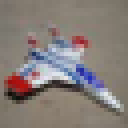

torch.Size([3, 32, 32])


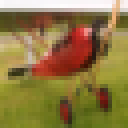

torch.Size([3, 32, 32])


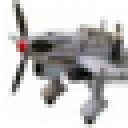

torch.Size([3, 32, 32])


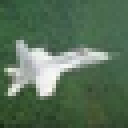

torch.Size([3, 32, 32])


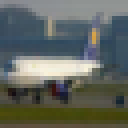

torch.Size([3, 32, 32])


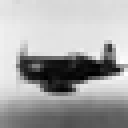

torch.Size([3, 32, 32])


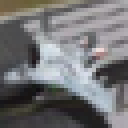

torch.Size([3, 32, 32])


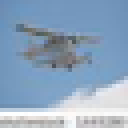

torch.Size([3, 32, 32])


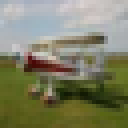

torch.Size([3, 32, 32])


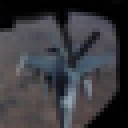

torch.Size([3, 32, 32])


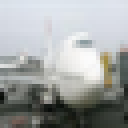

torch.Size([3, 32, 32])


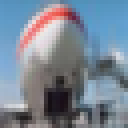

torch.Size([3, 32, 32])


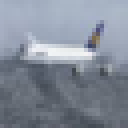

torch.Size([3, 32, 32])


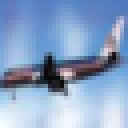

torch.Size([3, 32, 32])


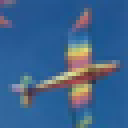

In [61]:
decisions_real=[]
for imgs in oneclass_dataloader:
    for img in imgs[0]:
        print(img.shape)
        img=img.view(1, 3, model.hparams.curr_res,model.hparams.curr_res)
        decisions_real.append(model.discriminator(img).detach().numpy())

        img_upsampled=(nn.Upsample(scale_factor=(4,4), mode='nearest')(img.view(1, 3, model.hparams.curr_res,model.hparams.curr_res)))[0]
        display(t(img_upsampled))
    break

In [69]:
for gen,real in zip(decisions_gen, decisions_real):
    print("Generated: ", gen[0,0], " Real: ", real[0,0])
    print("gen<real ", gen[0,0]<real[0,0])

Generated:  -4.4181376  Real:  -1.2722781
gen<real  True
Generated:  -6.2556033  Real:  -4.848649
gen<real  True
Generated:  -5.5879817  Real:  -3.893383
gen<real  True
Generated:  -4.917721  Real:  -2.5624747
gen<real  True
Generated:  -4.8817873  Real:  -4.4730077
gen<real  True
Generated:  -5.4743667  Real:  -4.1532536
gen<real  True
Generated:  -6.2892175  Real:  -5.5658054
gen<real  True
Generated:  -6.363208  Real:  -2.872729
gen<real  True
Generated:  -5.757255  Real:  -5.2259855
gen<real  True
Generated:  -4.8195705  Real:  -4.275109
gen<real  True
Generated:  -5.596702  Real:  -4.2752814
gen<real  True
Generated:  -5.9493127  Real:  -4.8099365
gen<real  True
Generated:  -6.106062  Real:  -4.376768
gen<real  True
Generated:  -7.167025  Real:  -5.0498586
gen<real  True
Generated:  -6.521382  Real:  -5.8561707
gen<real  True
Generated:  -4.8095055  Real:  -4.996714
gen<real  False
